<a href="https://colab.research.google.com/github/DrNelsonJatel/Testing-Social-Network-Metrics/blob/main/Synthetic_script_stats2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dataset loaded with shape: (100, 17)
✅ Saved standardized beta plots & CSV.
✅ Completed permutation tests & saved histograms.
✅ Created clustering dendrogram.


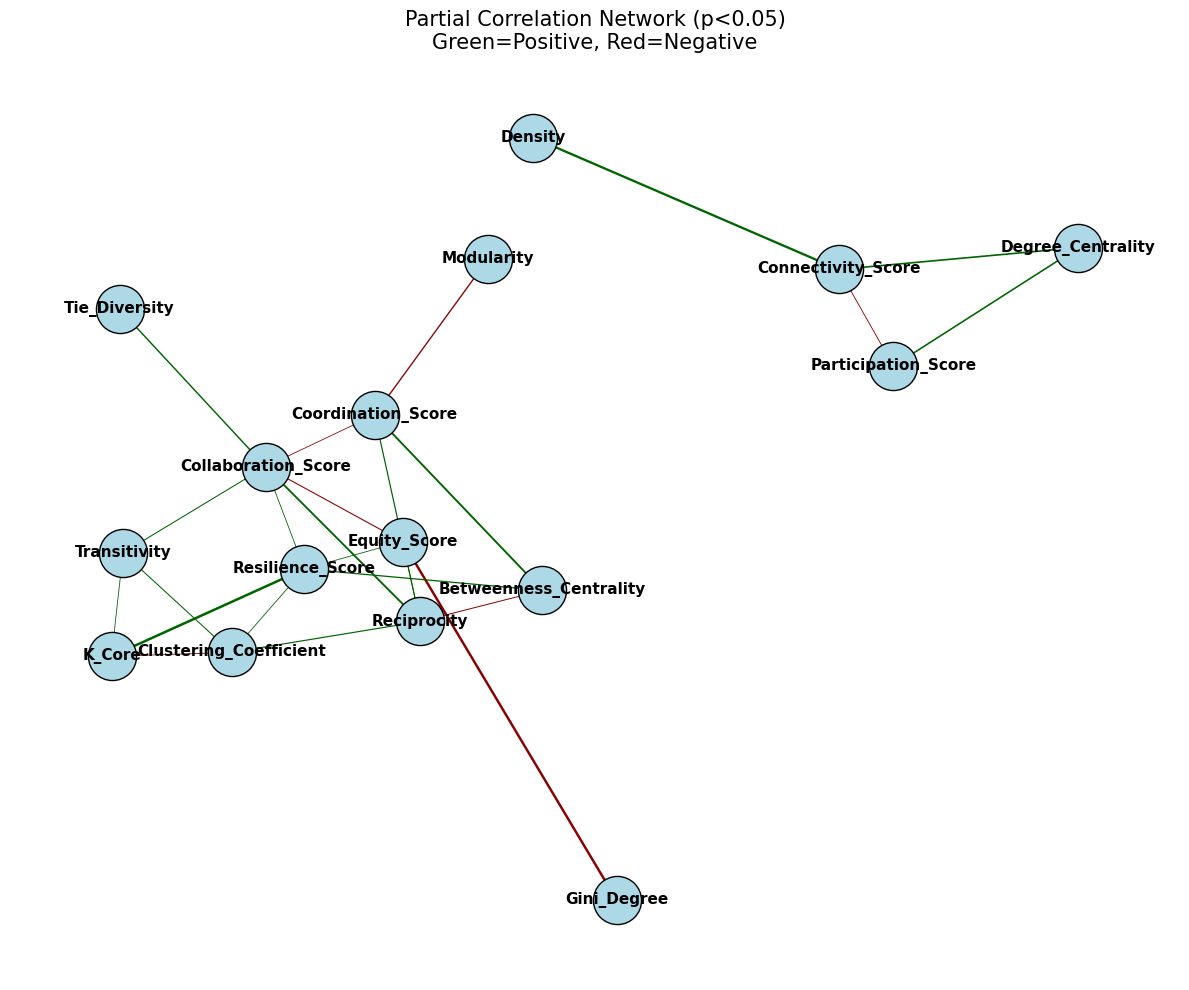

✅ Saved clean Kamada-Kawai partial correlation network.

=== Collaboration_Score ===
Shapiro-Wilk p-value: 0.4129
Breusch-Pagan p-value: 0.1819

=== Equity_Score ===
Shapiro-Wilk p-value: 0.5696
Breusch-Pagan p-value: 0.9982

=== Resilience_Score ===
Shapiro-Wilk p-value: 0.9819
Breusch-Pagan p-value: 0.7963
✅ Completed diagnostics: Shapiro, Breusch-Pagan, Cook's distance.
✅ Ran sensitivity check & saved pairplot of new synthetic dataset.


In [34]:
# ---------------------------
# IMPORTS
# ---------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, pearsonr
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.regressionplots import influence_plot
from scipy.cluster.hierarchy import linkage, dendrogram
import pingouin as pg
import networkx as nx
import itertools

# ---------------------------
# LOAD DATASET
# ---------------------------
df = pd.read_excel("/content/final_extended_synthetic_governance_dataset.xlsx")
print("✅ Dataset loaded with shape:", df.shape)

# ---------------------------
# STANDARDIZED BETA REGRESSIONS & COEFFICIENT PLOTS
# ---------------------------
models_to_run = {
    "Collaboration_Score": ["Reciprocity", "Transitivity", "Clustering_Coefficient"],
    "Equity_Score": ["Gini_Degree", "Tie_Diversity"],
    "Resilience_Score": ["K_Core", "Betweenness_Centrality"]
}

standardized_betas = []

for dep, indeps in models_to_run.items():
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[indeps])
    y_scaled = StandardScaler().fit_transform(df[[dep]])
    X_scaled = sm.add_constant(X_scaled)
    model = sm.OLS(y_scaled, X_scaled).fit()

    # Robust: guarantee numpy array
    ci_array = np.array(model.conf_int())

    for var, coef, ci in zip(["const"] + indeps, model.params, ci_array):
        if var != "const":
            standardized_betas.append({
                "Dependent": dep, "Predictor": var, "Std_Beta": coef,
                "95%_CI": f"({round(ci[0],2)}, {round(ci[1],2)})"
            })

    coefs = model.params[1:]
    lower_err = coefs - ci_array[1:,0]
    upper_err = ci_array[1:,1] - coefs

    plt.figure(figsize=(7,4))
    plt.errorbar(coefs, indeps,
                 xerr=[lower_err, upper_err],
                 fmt='o', color='black', capsize=4)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Standardized Betas for {dep}")
    plt.xlabel("Standardized Coefficient Estimate")
    plt.tight_layout()
    plt.savefig(f"standardized_betas_{dep}.png", dpi=300)
    plt.close()

pd.DataFrame(standardized_betas).to_csv("standardized_betas.csv", index=False)
print("✅ Saved standardized beta plots & CSV.")

# ---------------------------
# PERMUTATION TESTS
# ---------------------------
for dep, indeps in models_to_run.items():
    for indep in indeps:
        observed_r, _ = pearsonr(df[dep], df[indep])
        permuted_rs = []
        for _ in range(1000):
            shuffled = np.random.permutation(df[indep])
            r, _ = pearsonr(df[dep], shuffled)
            permuted_rs.append(r)
        plt.figure(figsize=(6,4))
        sns.histplot(permuted_rs, bins=30, color='gray')
        plt.axvline(observed_r, color='red', linestyle='--', lw=2)
        plt.title(f"Permutation Test: {dep} ~ {indep}")
        plt.xlabel("r under null")
        plt.tight_layout()
        plt.savefig(f"permutation_{dep}_vs_{indep}.png", dpi=300)
        plt.close()
print("✅ Completed permutation tests & saved histograms.")

# ---------------------------
# HIERARCHICAL CLUSTERING
# ---------------------------
all_metrics = ["Participation_Score","Connectivity_Score","Collaboration_Score",
               "Equity_Score","Resilience_Score","Coordination_Score",
               "Reciprocity","Transitivity","Gini_Degree","K_Core",
               "Modularity","Density","Degree_Centrality","Betweenness_Centrality",
               "Clustering_Coefficient","Tie_Diversity"]

corr = df[all_metrics].corr()
linked = linkage(corr, 'ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=corr.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering of Governance & SNA Metrics")
plt.tight_layout()
plt.savefig("dendrogram_governance_sna.png", dpi=300)
plt.close()
print("✅ Created clustering dendrogram.")

# ---------------------------
# PARTIAL CORRELATION NETWORK (Kamada-Kawai)
# ---------------------------
edges = []
for var1, var2 in itertools.combinations(all_metrics, 2):
    covar = [v for v in all_metrics if v not in [var1, var2]]
    result = pg.partial_corr(data=df, x=var1, y=var2, covar=covar, method='pearson')
    r = result.iloc[0]['r']
    p = result.iloc[0]['p-val']
    if p < 0.05:
        edges.append({"X": var1, "Y": var2, "r": r})

G = nx.Graph()
for e in edges:
    G.add_edge(e["X"], e["Y"], weight=abs(e["r"]), sign=e["r"])

pos = nx.kamada_kawai_layout(G, weight='weight')
plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200, edgecolors='black')
edge_colors = ['darkgreen' if G[u][v]['sign']>0 else 'darkred' for u,v in G.edges()]
edge_widths = [abs(G[u][v]['sign'])*2.5 for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
plt.title("Partial Correlation Network (p<0.05)\nGreen=Positive, Red=Negative", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.savefig("partial_corr_network_kamada_kawai_signed.png", dpi=300)
plt.show()
print("✅ Saved clean Kamada-Kawai partial correlation network.")

# ---------------------------
# RESIDUAL NORMALITY, HETEROSKEDASTICITY, COOK'S DISTANCE
# ---------------------------
for dep, indeps in models_to_run.items():
    X = sm.add_constant(df[indeps])
    y = df[dep]
    model = sm.OLS(y, X).fit()

    shapiro_p = shapiro(model.resid)[1]
    bp_p = het_breuschpagan(model.resid, model.model.exog)[1]

    print(f"\n=== {dep} ===")
    print(f"Shapiro-Wilk p-value: {shapiro_p:.4f}")
    print(f"Breusch-Pagan p-value: {bp_p:.4f}")

    fig, ax = plt.subplots(figsize=(7,4))
    influence_plot(model, ax=ax, criterion="cooks")
    plt.title(f"Cook's Distance Influence: {dep}")
    plt.tight_layout()
    plt.savefig(f"cooks_distance_{dep}.png", dpi=300)
    plt.close()
print("✅ Completed diagnostics: Shapiro, Breusch-Pagan, Cook's distance.")

# ---------------------------
# SENSITIVITY TEST: SLIGHTLY VARIED SYNTHETIC DATA
# ---------------------------
means = [3,3,3,3,3,3]
target_corr = np.array([
    [1.0, 0.5, 0.3, 0.0, 0.0, 0.0],
    [0.5, 1.0, 0.4, 0.0, 0.0, 0.0],
    [0.3, 0.4, 1.0,-0.5, 0.3, 0.0],
    [0.0, 0.0,-0.5, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.3, 0.0, 1.0, 0.5],
    [0.0, 0.0, 0.0, 0.0, 0.5, 1.0]
])
cov_matrix = target_corr * np.outer(np.ones(6), np.ones(6))

np.random.seed(42)
new_data = np.random.multivariate_normal(means, cov_matrix*1.1, size=100)
new_df = pd.DataFrame(new_data, columns=[
    "Participation_Score","Connectivity_Score","Collaboration_Score",
    "Equity_Score","Resilience_Score","Coordination_Score"
])
new_df = new_df.clip(1,5)
sns.pairplot(new_df)
plt.suptitle("Sensitivity Check: Slightly Varied Synthetic Data", y=1.02)
plt.tight_layout()
plt.savefig("sensitivity_synthetic_pairplot.png", dpi=300)
plt.close()
print("✅ Ran sensitivity check & saved pairplot of new synthetic dataset.")


In [15]:
!pip install pingouin


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.0 MB/s eta 0:00:00
